## Clustering Analysis on the cleaned and processed Data From the EDA layer

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import warnings
warnings.filterwarnings("ignore")

In [46]:
data = pd.read_csv('eda_final.csv')


### Taking random sample from the data ~5k

In [279]:
data_train = data.cleaned_text.sample(5000)
data_train.tail()

351763    first buy costco however longer go line find p...
16924     boxer's favorite treat healthy love smell good...
186629    drink mountain sun pure cranberry unsweetened ...
326266    yummy oatmeal like flax added oatmeal fiber pa...
105673    great tea ultra chai favorite flavor cup every...
Name: cleaned_text, dtype: object

In [284]:
# Initializing the tf-idf vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df=10)
data_features = tfidf.fit_transform(data_train)

In [285]:
# Now we will scale it 
std_Scaler = StandardScaler(with_mean=False)
std_data = std_Scaler.fit_transform(data_features)

### Plotting the elbow curve to chose the k-Value

In [286]:
# Defining a function to find the optimal k
def find_optimal_k(std_data):
    loss = []
    k = list(range(2, 15))
    for noc in k:
        model = KMeans(n_clusters = noc)
        model.fit(std_data)
        loss.append(model.inertia_)
    plt.plot(k, loss, "-o")
    plt.title("Elbow method to choose k")
    plt.xlabel("K")
    plt.ylabel("Loss")
    plt.show()

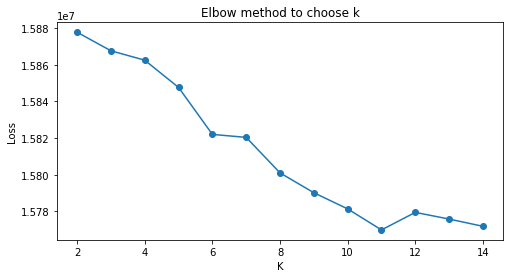

In [287]:
find_optimal_k(std_data)

#### We can see that after k=6 there not much difference so we are safe to chose the value of k=6.

In [306]:
# Kmeans to 
k_Means = KMeans(n_clusters = 5)
k_Means.fit(std_data)
pred = k_Means.predict(std_data)

In [307]:
k_Means.cluster_centers_.shape

(5, 3180)

In [308]:
# Plot each cluster features in a cloud
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
#     print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(3, 3, figsize = (30, 20))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 50)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {}".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()

In [309]:
features = tfidf.get_feature_names()
coef = k_Means.cluster_centers_

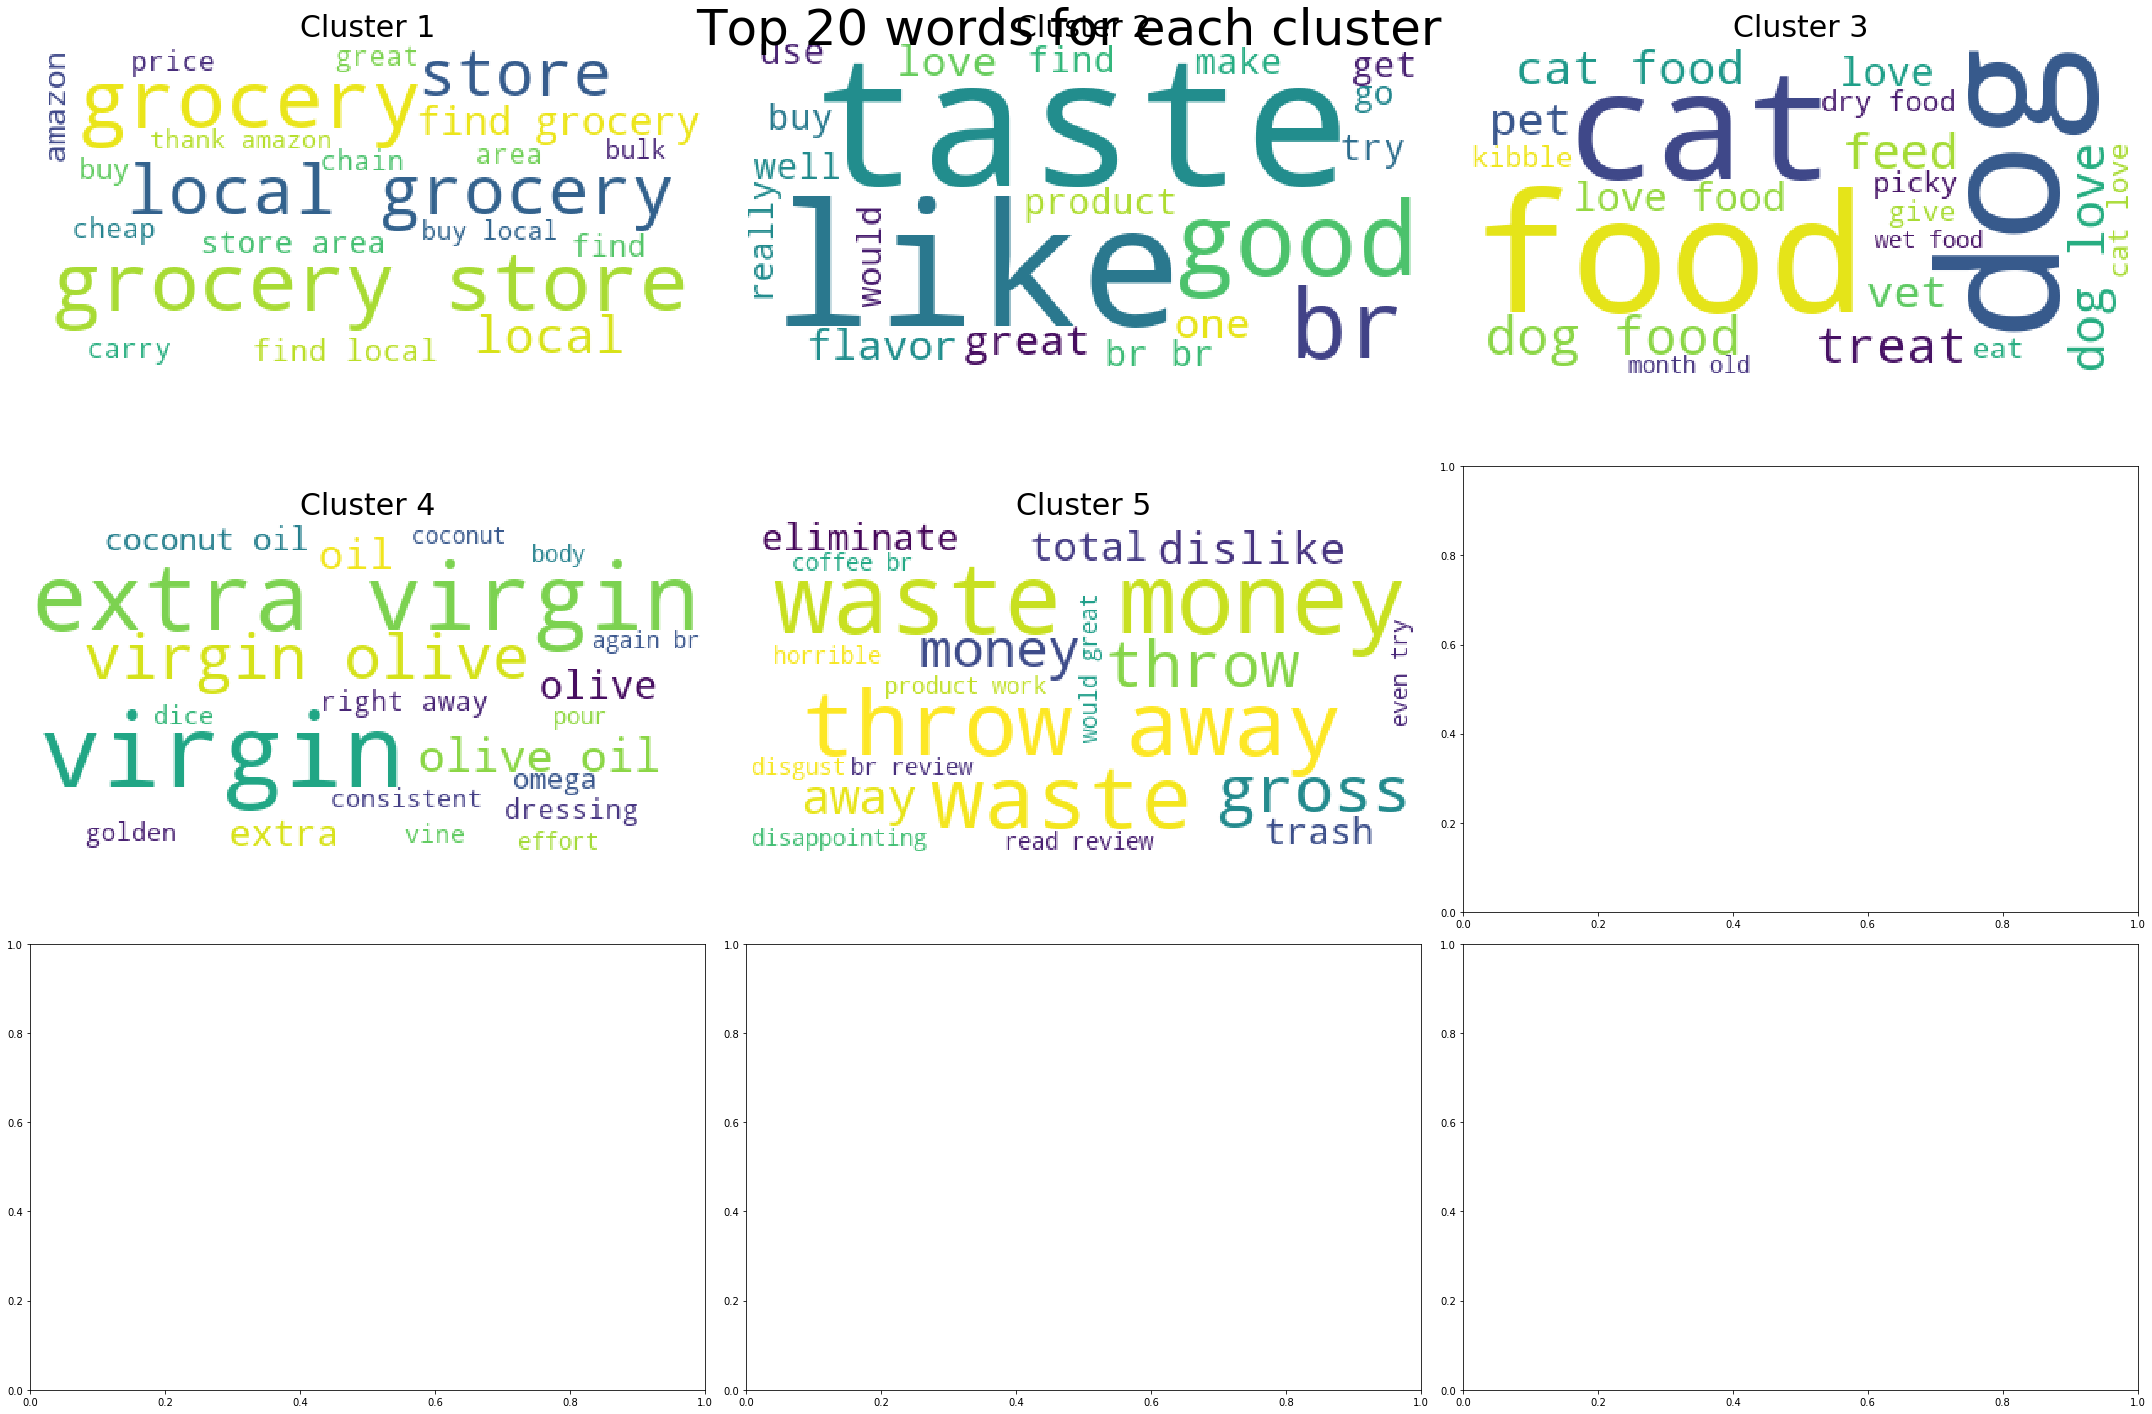

In [310]:
plot_cluster_cloud(features, coef)

#### Understanding the dimensions of the features generated from tf-idf vectorizatiom

In [311]:
data_features.shape

(5000, 3180)

#### It's a little visible that the words grouped together are not of the same type.
#### It's quiet clear that it would not be an easy task to visualize this. So we will use Dimensionality reduction to tackle this situation. Let us coonsider a 2D breakdown of the features.


## PCA- For 2D Visualisation

In [312]:
from sklearn.decomposition import PCA

In [313]:
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(std_data.toarray())

reduced_cluster_centers = pca.transform(k_Means.cluster_centers_)

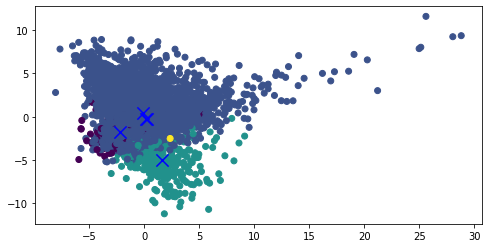

In [314]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=k_Means.predict(std_data))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.rcParams["figure.figsize"] = (8,4)

## Now, performing some cluster validation to check the metrics for our cluster
- As we do not have labelled data we cannot go ahead with homegenity score so we will go ahead with silhouette_score

In [315]:
from sklearn.metrics import silhouette_score
silhouette_score(std_data, labels=k_Means.predict(std_data))

-0.006220084373939712

#### A negative value indicates a not so good clustering of the data which is also visible from the cluster scatter plot.
- A plausible reason for this maybe that the data has lot of positive sentiment so the cluster appears to be biased.

### One solution can be to sample reviews from positive and negative sentiment to analyze the clusters thereafter. This is implemented below.

In [298]:
data_pos = data[data.score_pos_neg == 'positive'].sample(2500)
data_pos.tail()

data_neg = data[data.score_pos_neg == 'negative'].sample(2500)
data_neg.tail()

# type(data_pos)
data_train_equalized = pd.concat([data_pos,data_neg])
data_train_equalized= data_train_equalized.cleaned_text
data_train_equalized.shape

(5000,)

In [299]:
# Initializing the tf-idf vectorizer
tfidf_2 = TfidfVectorizer(ngram_range=(1,2),min_df=10)
data_features_2 = tfidf_2.fit_transform(data_train_equalized)

In [300]:
# Now we will scale it 
std_Scaler_2 = StandardScaler(with_mean=False)
std_data_2 = std_Scaler_2.fit_transform(data_features_2)

### Plotting the elbow curve to chose the k-Value

In [301]:
# Defining a function to find the optimal k
def find_optimal_k(std_data):
    loss = []
    k = list(range(2, 15))
    for noc in k:
        model = KMeans(n_clusters = noc)
        model.fit(std_data)
        loss.append(model.inertia_)
    plt.plot(k, loss, "-o")
    plt.title("Elbow method to choose k")
    plt.xlabel("K")
    plt.ylabel("Loss")
    plt.show()

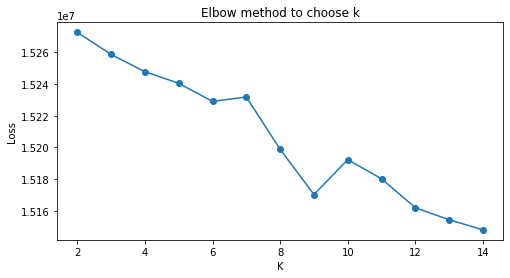

In [302]:
find_optimal_k(std_data_2)

#### We can see that after k=6 there not much difference so we are safe to chose the value of k=6

In [259]:
# Kmeans to 
k_Means_2 = KMeans(n_clusters = 6)
k_Means_2.fit(std_data_2)
pred_2 = k_Means_2.predict(std_data_2)

In [260]:
k_Means_2.cluster_centers_.shape

(7, 3058)

In [261]:
# Plot each cluster features in a cloud
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
#     print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(2, 5, figsize = (30, 20))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 50)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {}".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()

In [262]:
features_2 = tfidf_2.get_feature_names()
coef_2 = k_Means_2.cluster_centers_

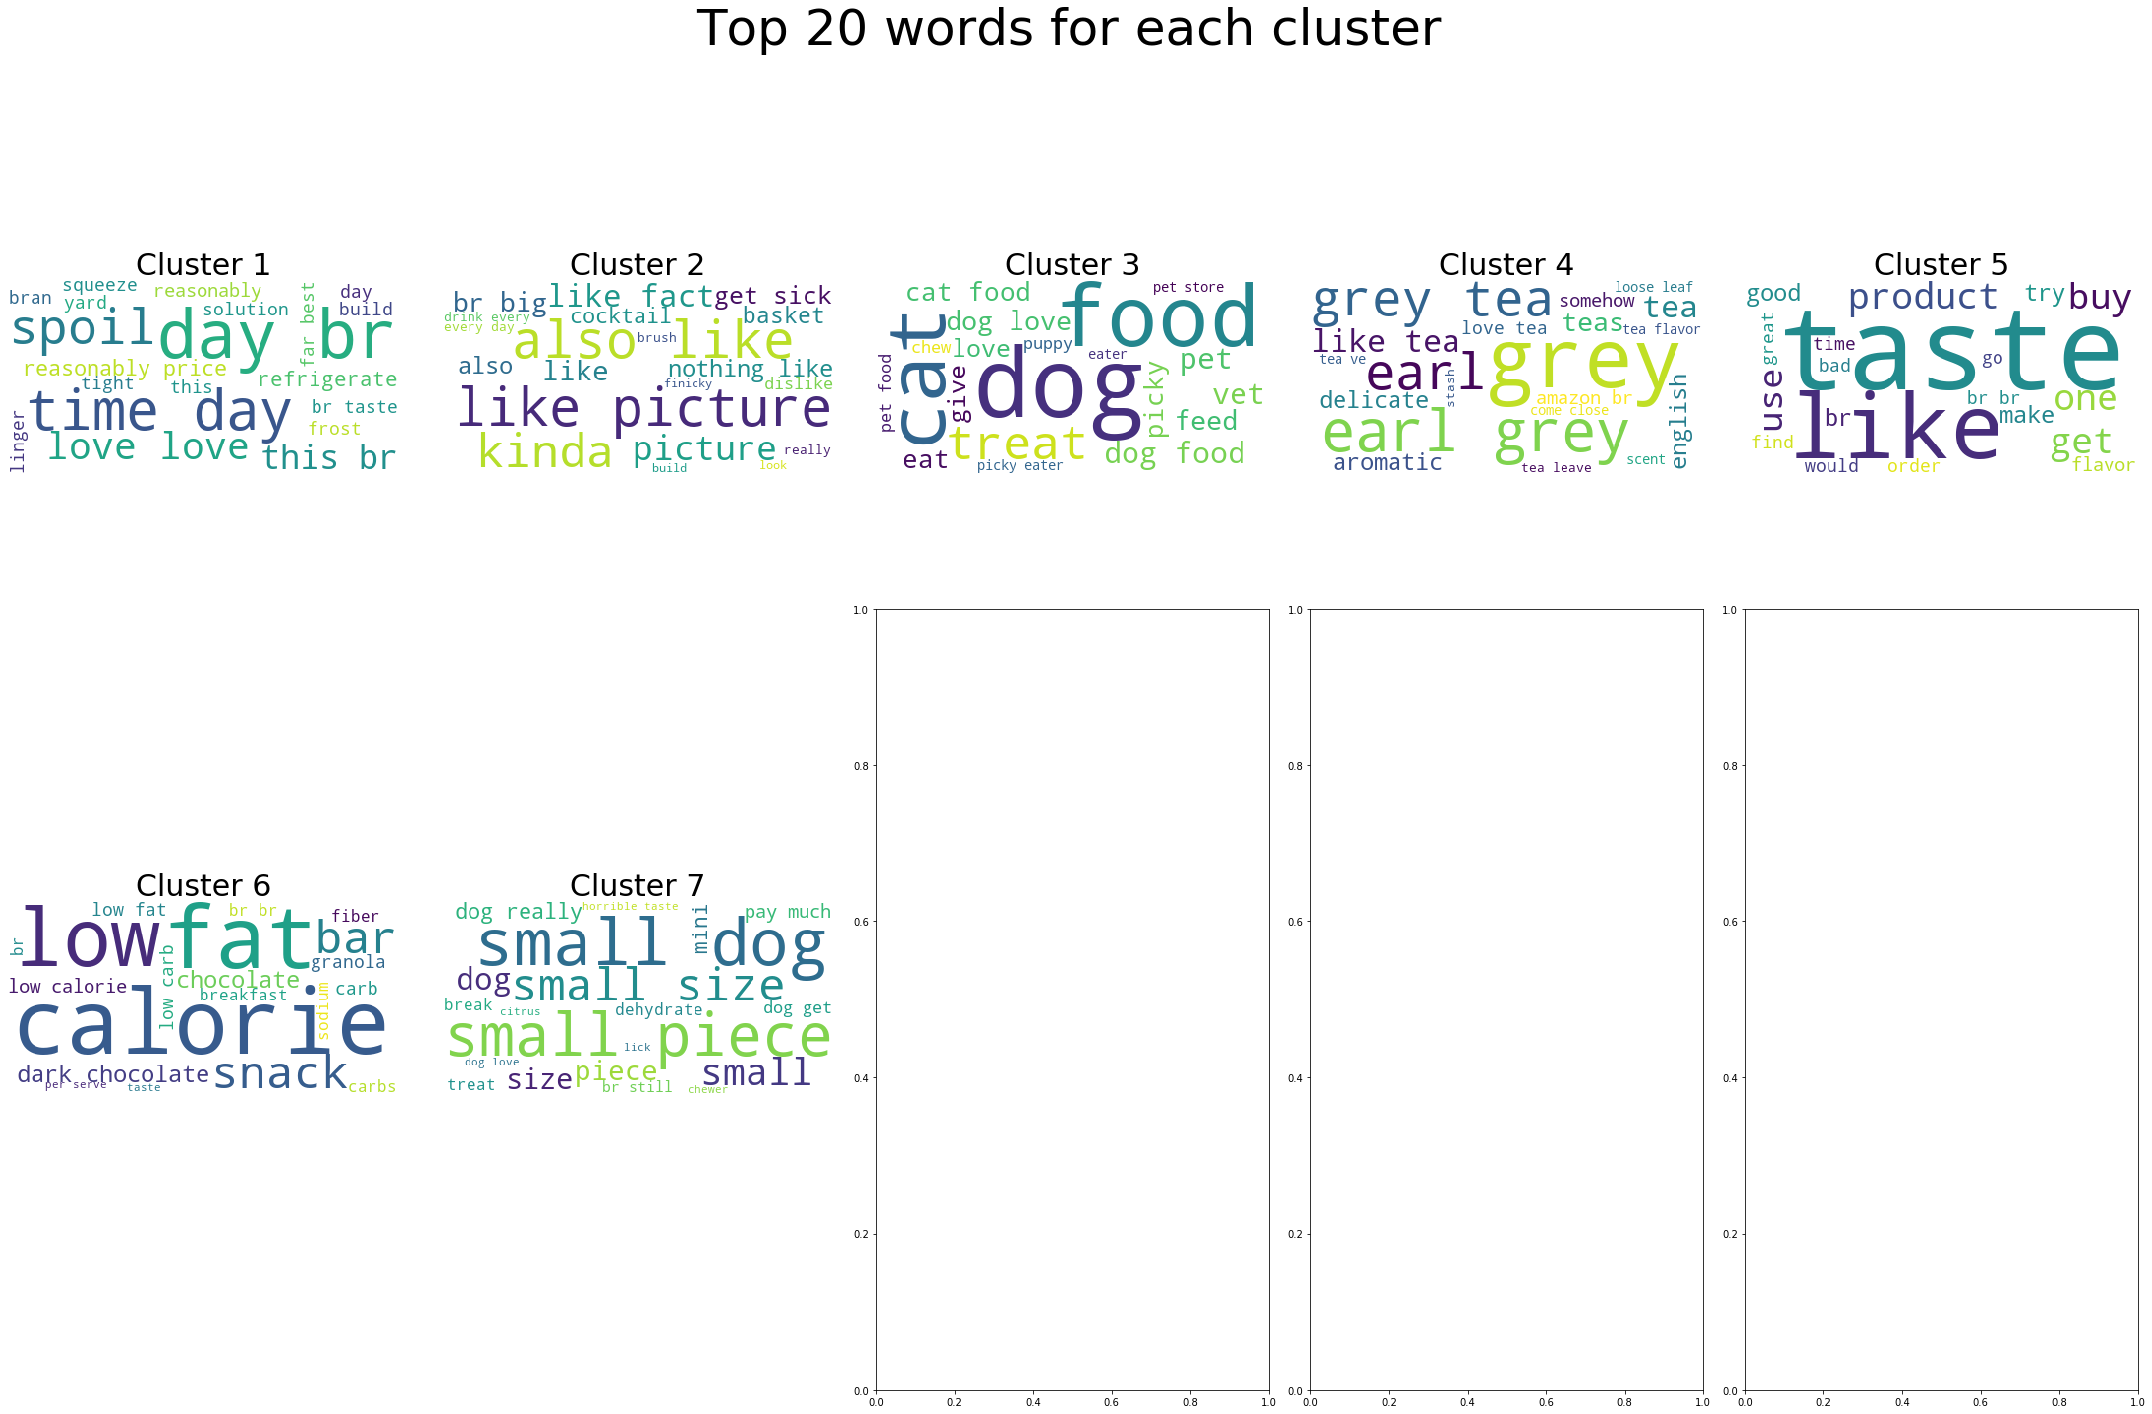

In [263]:
plot_cluster_cloud(features_2, coef_2)

#### Understanding the dimensions of the features generated from tf-idf vectorizatiom

In [264]:
data_features_2.shape

(5000, 3058)

#### It's a little visible that the words grouped together are not of the same type.

#### It's quiet clear that it would not be an easy task to visualize this. So we will use Dimensionality reduction to tackle this situation. Let us coonsider a 2D breakdown of the features.


## PCA- For 2D Visualisation

In [265]:
from sklearn.decomposition import PCA

In [266]:
pca_2 = PCA(n_components=2, random_state=0)
reduced_features_2 = pca.fit_transform(std_data_2.toarray())

reduced_cluster_centers_2 = pca.transform(k_Means_2.cluster_centers_)

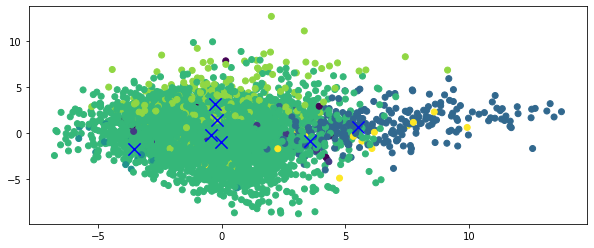

In [267]:
plt.scatter(reduced_features_2[:,0], reduced_features_2[:,1], c=k_Means_2.predict(std_data_2))
plt.scatter(reduced_cluster_centers_2[:, 0], reduced_cluster_centers_2[:,1], marker='x', s=150, c='b')
plt.rcParams["figure.figsize"] = (10,4)

## Now, performing some cluster validation to check the metrics for our cluster
- As we do not have labelled data we cannot go ahead with homegenity score so we will go ahead with silhouette_score

In [268]:
from sklearn.metrics import silhouette_score
silhouette_score(std_data_2, labels=k_Means_2.predict(std_data_2))

0.00336632104538637

#### A negative value indicates a not so good clustering of the data which is also visible from the cluster scatter plot.
- But we see that there is some increase in the score here... which indicates a little better clustering